In [1]:
# standard libraries to import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Set the display format to show only 2 decimal places
np.set_printoptions(precision=2, suppress=True)

In [2]:
# import training data
data = pd.read_csv('data/train.csv')

In [3]:
# each row is a training example, i.e. each row is an image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# convert data to numpy array
data = np.array(data)
data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

In [5]:
# row, column (column is +1 cause of label column)
data.shape

(42000, 785)

In [6]:
# shuffle the elements, in-place
# essentially,k shuffles the order of images, since an element (a list) is an image
np.random.shuffle(data)
data

array([[9, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [9, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]])

In [7]:
# validation set: transforming to make each training example a column
data_dev = data[0:1000].T
# since first row is labels now, this works cause of the transform
Y_dev = data_dev[0]
X_dev = data_dev[1:data_dev.shape[0]]
# normalize values, this is an important step, but why? 
# it's probably because the weights are so small, they work better with smaller values, maybe
# also easier to process smaller values
X_dev = X_dev / 255

# training data
data_train = data[1000:data.shape[0]].T
Y_train = data_train[0]
X_train = data_train[1:data_train.shape[0]]
X_train = X_train / 255

In [8]:
Y_train # our labels

array([3, 6, 3, ..., 9, 1, 5])

In [9]:
X_train # our image data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
X_train[0].shape # this is the first row, cause there are 42k samples in total

(41000,)

In [12]:
# gives rows, cols. Makes sense, cause each column is an example
# so # of rows will be # of pixels in an image essentially
X_train[:].shape 

(784, 41000)

In [13]:
X_train[:,0].shape # this is the first column, essentially first element of each list

(784,)

In [14]:
# randn: mean = 0, variance = 1, normal distribution
# rand: uniform distribution over [0,1)]
np.random.rand()

0.438165132895873

In [15]:
# weights and biases for hidden layers and output layer
# lC = layerCount, nC = neuronCount, fC = featureCount, cC = classLabelCount
def init_params(lC, nC, fC, cC):
    # adding the first hidden layer, cause it's based on fC
    weights = [np.random.rand(nC, fC) - 0.5]
    biases = [np.random.rand(nC, 1) - 0.5]

    for i in range(1, lC):
        weights_layer = np.random.rand(nC, nC) - 0.5
        weights.append(weights_layer)

        bias_layer = np.random.rand(nC, 1) - 0.5
        biases.append(bias_layer)

    # output layer, # of neurons = class labels
    weights.append(np.random.rand(cC, nC) - 0.5)
    biases.append(np.random.rand(cC, 1)  - 0.5)
    
    return weights, biases

# essentially linear after 0, prior to 0, outputs 0
def ReLU(Z):
    return np.maximum(Z, 0) # element wise

# need clarification here...
def softmax(Z):
    # np.sum() preserves each column, collapses the rows
    # we still want to preserve each column
    # np.exp(Z) is element wise
    # so we are dividing each element with the sum of elements in that same column
    A = np.exp(Z) / sum(np.exp(Z)) # not np.sum()?
    
    return A

# encoding labels into a vector format
def one_hot(Y):
    # creating empty matrix of sampleSize, # of classes
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    # based on the label value, fill that element in each array to be 1
    one_hot_Y[np.arange(Y.size), Y] = 1
    # to get each column to be an example
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y

def forward_prop(X, weights, biases, lC):
    # first hidden layer
    Z_layer = weights[0].dot(X) + biases[0]
    A_layer = ReLU(Z_layer)

    Zs = [Z_layer]
    As = [A_layer]

    # remaining hiddden layers
    for i in range(1, lC):
        Z_layer = weights[i].dot(As[i-1]) + biases[i]
        A_layer = ReLU(Z_layer)

        Zs.append(Z_layer)
        As.append(A_layer)

    # output layer
    Z_layer = weights[-1].dot(As[-1]) + biases[-1]
    A_layer = softmax(Z_layer)

    Zs.append(Z_layer)
    As.append(A_layer)
    
    return Zs, As

# derivative past 0 is 1, cause y=x, prior to 0, it's 0. So this returns 1 or 0
def deriv_ReLU(Z):
    return Z > 0

# essentially reverse logic of forward_prop, this was a tough one!!!!!!
def back_prop(Zs, As, weights, biases, X, Y, lC):
    m = X_train.shape[1] # number of examples
    
    # last layer is based on output, that's why the hot_y part...hot y...sexy
    dZ_layer = As[-1] - one_hot(Y)
    dW_layer = 1/m * dZ_layer.dot(As[-2].T)
    dB_layer = 1/m * np.sum(dZ_layer)

    dWs = [dW_layer]
    dBs = [dB_layer]

    # logic for hidden layers
    for i in range(1, lC):
        dZ_layer = weights[-i].T.dot(dZ_layer)*deriv_ReLU(Zs[-i-1])
        dW_layer = 1/m * dZ_layer.dot(As[-i-2].T)
        dB_layer = 1/m * np.sum(dZ_layer)

        dWs.append(dW_layer)
        dBs.append(dB_layer)

    # logic for first hidden layer, cause it depends on input
    dZ_layer = weights[1].T.dot(dZ_layer)*deriv_ReLU(Zs[0])
    dW_layer = 1/m * dZ_layer.dot(X.T)
    dB_layer = 1/m * np.sum(dZ_layer)

    dWs.append(dW_layer)
    dBs.append(dB_layer)
    
    return dWs, dBs

# output of output layer, in probabilities 
def get_predictions(A):
    return np.argmax(A, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    # essentially when prediciton matches Y, sum those, vs. total Y size
    return np.sum(predictions == Y) / Y.size 

# optimizer, based on alpha (learning rate)
# input will be a numpy array of weights and biases, and derivates
def update_params(weights, biases, dWs, dBs, alpha):
    for i in range(len(weights)):
        weights[i] = weights[i] - alpha*dWs[-i-1]
        biases[i] = biases[i] - alpha*dBs[-i-1]
    
    return weights, biases

In [16]:
def gradient_descent(X, Y, iterations, lC, nC, cC, alpha):
    fC = X_train.shape[0]
    
    weights, biases = init_params(lC, nC, fC, cC)

    for i in range(iterations):
        Zs, As = forward_prop(X_train, weights, biases, lC)
        dWs, dBs = back_prop(Zs, As, weights, biases, X_train, Y_train, lC)

        weights, biases = update_params(weights, biases, dWs, dBs, alpha)

        if i % 50 == 0:
            print('Iteration: ', i)
            print('Accuracy: ', get_accuracy(get_predictions(As[-1]), Y_train))
            
    return weights, biases

In [17]:
# define inputs to the network design
lC = 1 # hidden layerCount, does not include output layer > 0
nC = 10 # neuronCount > 0
cC = 10 # classLabelCount
alpha = .1 # learning rate
iterations = 1000

weights, biases = gradient_descent(X_train, Y_train, iterations, lC, nC, cC, alpha)

Iteration:  0
[5 1 7 ... 2 2 7] [3 6 3 ... 9 1 5]
Accuracy:  0.11119512195121951
Iteration:  50
[5 1 2 ... 4 2 5] [3 6 3 ... 9 1 5]
Accuracy:  0.36958536585365853
Iteration:  100
[5 2 2 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.5293414634146342
Iteration:  150
[5 2 2 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.6409756097560976
Iteration:  200
[5 2 2 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.7223658536585366
Iteration:  250
[3 2 2 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.7731951219512195
Iteration:  300
[3 2 3 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.8003170731707318
Iteration:  350
[3 2 3 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.8171219512195121
Iteration:  400
[3 2 3 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.8291219512195122
Iteration:  450
[3 2 3 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.8394146341463414
Iteration:  500
[3 2 3 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.8470243902439024
Iteration:  550
[3 2 3 ... 9 1 5] [3 6 3 ... 9 1 5]
Accuracy:  0.852170731707317
Iteration:  600
[3

In [18]:
def make_predictions(X, weights, biases, lC):
    _, As = forward_prop(X, weights, biases, lC)
    prediction = get_predictions(As[-1]) # last one is from the output layer
    
    return prediction 

In [21]:
def test_prediction(index, weights, biases, lC):
    current_image = X_dev[:, index, None]
    prediction = make_predictions(X_dev[:, index, None], weights, biases, lC)
    label = Y_dev[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  9


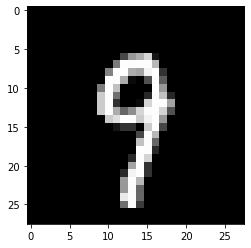

Prediction:  [5]
Label:  5


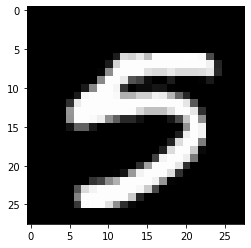

Prediction:  [4]
Label:  4


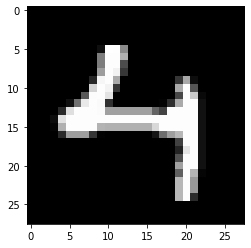

Prediction:  [7]
Label:  7


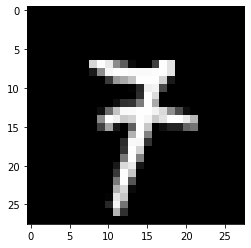

Prediction:  [5]
Label:  5


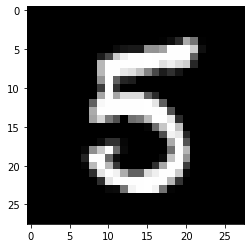

In [22]:
test_prediction(0, weights, biases, lC)
test_prediction(1, weights, biases, lC)
test_prediction(2, weights, biases, lC)
test_prediction(3, weights, biases, lC)
test_prediction(4, weights, biases, lC)